On commence par importer les librairies nécessaires

In [87]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pulp as pl

#### 1. Partie Commune


1) Génerer les noeuds et l'ensemble des arcs aléatoirement

In [88]:
N= np.random.randint(20, 100)
A= np.random.randint(50, 100)

Génerer les noeuds et l'ensemble des arcs aléatoirement

In [89]:
G=nx.gnm_random_graph(N,A,directed=True)

Identifier les boucles et les supprimer

In [90]:
boucles=list(nx.selfloop_edges(G))
G.remove_edges_from(boucles)

Afficher le graphe

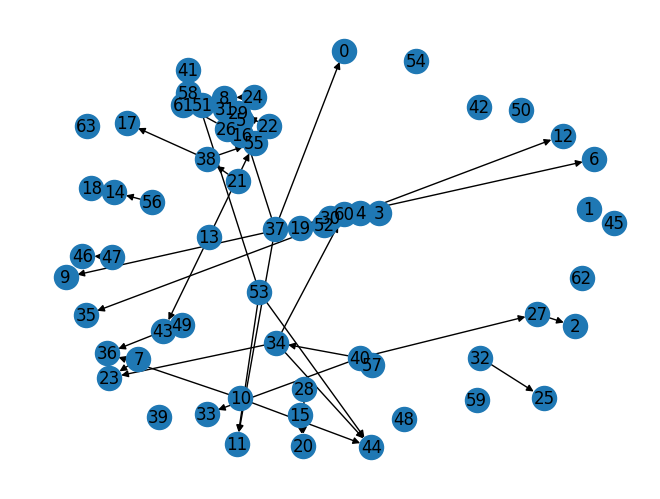

In [91]:
nx.draw_spring(G,with_labels=True)
plt.show()

Vérifier si le nombre de noeuds et le nombre d'arcs générés sont corrects.

In [92]:
print("Le nombre de noeuds initialisé est", N, "et le nombre de noeuds du graphe est:", G.number_of_nodes())
print("Le nombre d'arcs initialisé est", A, "et le nombre d'arcs du graphe est:", G.number_of_edges())

Le nombre de noeuds initialisé est 64 et le nombre de noeuds du graphe est: 64
Le nombre d'arcs initialisé est 53 et le nombre d'arcs du graphe est: 53


2) Définir U et C et affecter les coûts et les capacités aléatoirement sur les arcs dans les intervalles [0,C] et [0,U] respectivement

In [93]:
U,C=20,50
for i, j in G.edges():
    G[i][j]['u'] = np.random.randint(0, U)
    G[i][j]['c'] = np.random.randint(0, C)

# Print the capacities and costs of each edge
for i, j in G.edges():
    print(f"({i}, {j}): U = {G[i][j]['u']}, C = {G[i][j]['c']}")

(3, 4): U = 15, C = 39
(4, 60): U = 1, C = 22
(5, 51): U = 13, C = 11
(7, 23): U = 13, C = 10
(8, 51): U = 13, C = 8
(10, 36): U = 18, C = 29
(10, 44): U = 19, C = 11
(13, 43): U = 12, C = 44
(13, 55): U = 6, C = 21
(14, 18): U = 15, C = 14
(15, 20): U = 8, C = 5
(16, 26): U = 7, C = 10
(19, 52): U = 5, C = 4
(19, 37): U = 10, C = 20
(21, 38): U = 11, C = 46
(22, 29): U = 8, C = 24
(24, 8): U = 12, C = 47
(26, 61): U = 18, C = 41
(27, 2): U = 19, C = 4
(28, 20): U = 1, C = 29
(29, 31): U = 2, C = 39
(29, 22): U = 19, C = 32
(29, 58): U = 18, C = 0
(30, 6): U = 18, C = 28
(30, 9): U = 1, C = 36
(31, 58): U = 5, C = 14
(32, 25): U = 12, C = 40
(34, 60): U = 16, C = 0
(34, 23): U = 10, C = 36
(34, 44): U = 9, C = 41
(37, 0): U = 19, C = 25
(37, 11): U = 18, C = 21
(37, 29): U = 5, C = 48
(38, 17): U = 11, C = 14
(38, 55): U = 18, C = 3
(40, 34): U = 7, C = 37
(40, 27): U = 17, C = 11
(40, 33): U = 18, C = 33
(43, 36): U = 4, C = 5
(47, 46): U = 7, C = 47
(49, 43): U = 5, C = 18
(51, 61): 

#### 3. Problème de flot à coût minimum avec capacité


1. Définir un ensemble de sources S ⊆ N et un ensemble de destinations T ⊆ N

In [94]:
S = set(np.random.choice(list(G.nodes()), size=5, replace=False))
T = set(np.random.choice(list(G.nodes()), size=8, replace=False))
while not S.isdisjoint(T):
    T = set(np.random.choice(list(G.nodes()), size=8, replace=False))

Vérifier qu'ils sont disjoints

In [95]:
while len(S.intersection(D)) > 0:
    T = set(np.random.sample(8))

Afficher S et T

In [96]:
print("Sources:", S)
print("Destinations:", D)

Sources: {4, 40, 45, 18, 51}
Destinations: {0.23713852175189543, 0.49685627231955753, 0.5185733700114115, 0.7199889973971271, 0.9293119503582015, 0.025246997516692238, 0.4220106108834317, 0.869869114859895, 0.9380522365148013}


2. affecter des valeurs d’offre de trafic sur les noeuds sources dans l’intervalle $[0,\overline{\rm ds}]$


In [97]:
ds_bar = 1000
for i in S:
        G.nodes[i]['traffic_offer'] = np.random.uniform(0, ds_bar)

3. affectez des valeurs de demande de trafic sur les noeuds destinations dans l’intervalle $[0,\overline{\rm dt}]$

In [98]:
dt_bar = 1000
for i in T:
    G.nodes[i]['traffic_demand'] = np.random.uniform(0, dt_bar)

4. Résolution du problème d'optimisation

In [99]:
# Création du problème linéaire en utilisant la méthode LpProblem de la librairie pulp
prob = pl.LpProblem("Probleme_de_flot_a_cout_minimum", pl.LpMinimize)

# Création des variables de décision
variables = pl.LpVariable.dicts("Flux", ((i, j) for (i, j) in G.edges()), lowBound=0, cat='Continuous')

# Ajout de la fonction objectif
prob += pl.lpSum([G[i][j]['c'] * variables[(i, j)] for (i, j) in G.edges()]), "Cout_Total_du_Flux"

# Ajout de la contrainte de conservation de flux pour chaque nœud
for node in G.nodes():
    if node not in S.union(T):
        prob += pl.lpSum([variables[(i, j)] for (i, j) in G.in_edges(node)]) \
                == pl.lpSum([variables[(i, j)] for (i, j) in G.out_edges(node)]), f"Conservation_Flux_{node}"

# Ajout des contraintes de capacité pour chaque arc
for (i, j) in G.edges():
    prob += variables[(i, j)] <= G[i][j]['u'], f"Capacite_{(i, j)}"

# Ajout de la contrainte de demande à satisfaire pour chaque nœud destination
for node in T:
    prob += pl.lpSum([variables[(i, j)] for (i, j) in G.in_edges(node)]) \
            == G.nodes[node]['traffic_demand'], f"Demande_{node}"

# Ajout de la contrainte d'offre pour chaque nœud source
for node in S:
    prob += pl.lpSum([variables[(i, j)] for (i, j) in G.out_edges(node)]) \
            == G.nodes[node]['traffic_offer'], f"Offre_{node}"

# Résolution du problème d'optimisation
prob.solve()

# Affichage de la solution optimale
print(f"Le coût total minimal du flux est de {pl.value(prob.objective)}")

# Affichage des variables de base optimales
for (i, j) in G.edges():
    if variables[(i, j)].varValue > 0:
        print(f"Flux de ({i}, {j}) = {variables[(i, j)].varValue}")


Le coût total minimal du flux est de 91130.30119
Flux de (30, 9) = 792.4155
Flux de (40, 27) = 17.0
Flux de (40, 33) = 928.05183
Flux de (51, 61) = 794.76582
